<a href="https://colab.research.google.com/github/gizemkaratas/Customer_Churn/blob/main/Customer_Churn_telco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML ile Müşteri Terk Tahmini**

---



In [383]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [384]:
df=pd.read_csv('Telco-Customer-Churn.csv')

Sütun Adı	Açıklama
* CustomerId	Müşteri İd’si
* Gender	Cinsiyet
* SeniorCitizen	Müşterinin yaşlı olup olmadığı (1, 0)
* Partner	Müşterinin bir ortağı olup olmadığı (Evet, Hayır)
* Dependents	Müşterinin bakmakla yükümlü olduğu kişiler olup olmadığı (Evet, Hayır)
* Tenure	Müşterinin şirkette kaldığı ay sayısı
* PhoneService	Müşterinin telefon hizmeti olup olmadığı (Evet, Hayır)
* MultipleLines	Müşterinin birden fazla hattı olup olmadığı (Evet, Hayır, Telefon hizmeti yok)
* InternetService	Müşterinin internet servis sağlayıcısı (DSL, Fiber optik, Hayır)
* OnlineSecurity	Müşterinin çevrimiçi güvenliğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* OnlineBackup	Müşterinin online yedeğinin olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* DeviceProtection	Müşterinin cihaz korumasına sahip olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* TechSupport	Müşterinin teknik destek alıp almadığı (Evet, Hayır, İnternet hizmeti yok)
* StreamingTV	Müşterinin TV yayını olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* StreamingMovies	Müşterinin film akışı olup olmadığı (Evet, Hayır, İnternet hizmeti yok)
* Contract	Müşterinin sözleşme süresi (Aydan aya, Bir yıl, İki yıl)
* PaperlessBilling	Müşterinin kağıtsız faturası olup olmadığı (Evet, Hayır)
* PaymentMethod	Müşterinin ödeme yöntemi (Elektronik çek, Posta çeki, Banka havalesi (otomatik), Kredi kartı (otomatik))
* MonthlyCharges	Müşteriden aylık olarak tahsil edilen tutar
* TotalCharges	Müşteriden tahsil edilen toplam tutar
* Churn	Müşterinin kullanıp kullanmadığı (Evet veya Hayır)

In [385]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [386]:
df.shape

(7043, 21)

In [387]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000,7043.000,7043.000
mean,0.162,32.371,64.762
std,0.369,24.559,30.090
min,0.000,0.000,18.250
25%,0.000,9.000,35.500
50%,0.000,29.000,70.350
75%,0.000,55.000,89.850
max,1.000,72.000,118.750


In [388]:
df.isnull().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [389]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [390]:
# prompt: TotalCharges i float64 e çevrilmesi

import pandas as pd
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype(float)


In [391]:
# prompt: churn yes ise 1 no ise 0 ile değiştirilmesi

df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)


# **Değişken Analizi ve Hata Düzeltimi:**

In [392]:
#Değişken analizinin yapılması

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f'Kategorik Sütunlar: {len(cat_cols)}')
    print(f'Sayısal Sütunlar: {len(num_cols)}')
    print(f'Yüksek Kardinaliteli Kategorik Sütunlar: {len(cat_but_car)}')
    print(f'Sayısal Görünen Kategorik Sütunlar: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Gözlemler: 7043
Değişkenler: 21
Kategorik Sütunlar: 17
Sayısal Sütunlar: 3
Yüksek Kardinaliteli Kategorik Sütunlar: 1
Sayısal Görünen Kategorik Sütunlar: 2


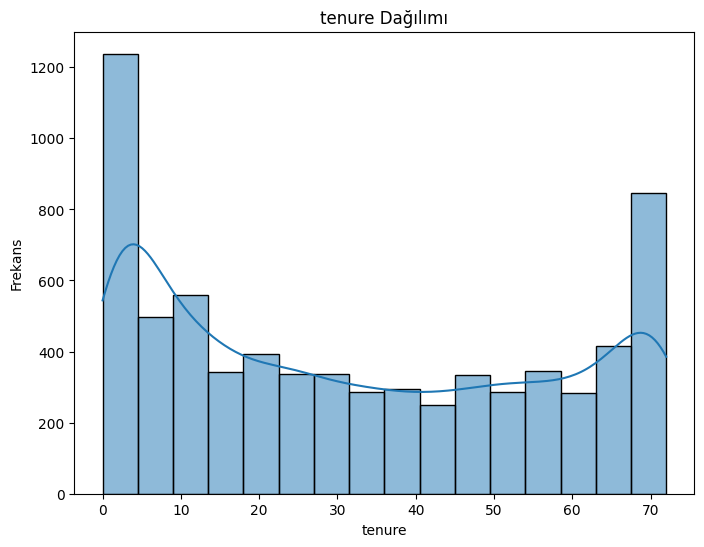

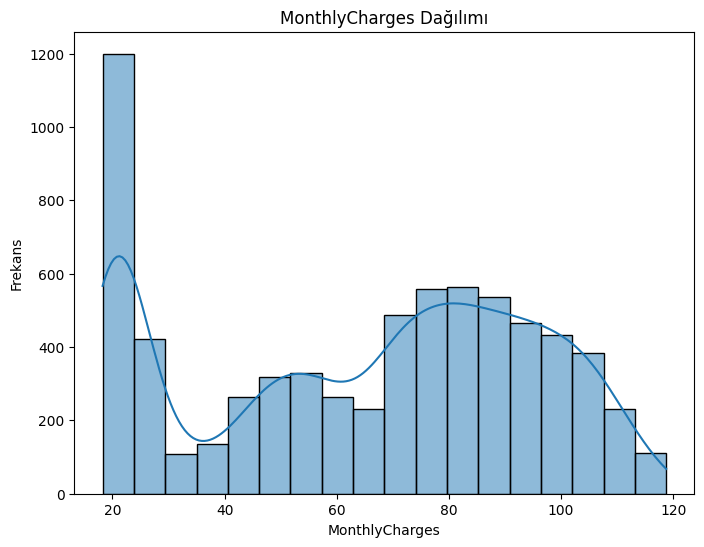

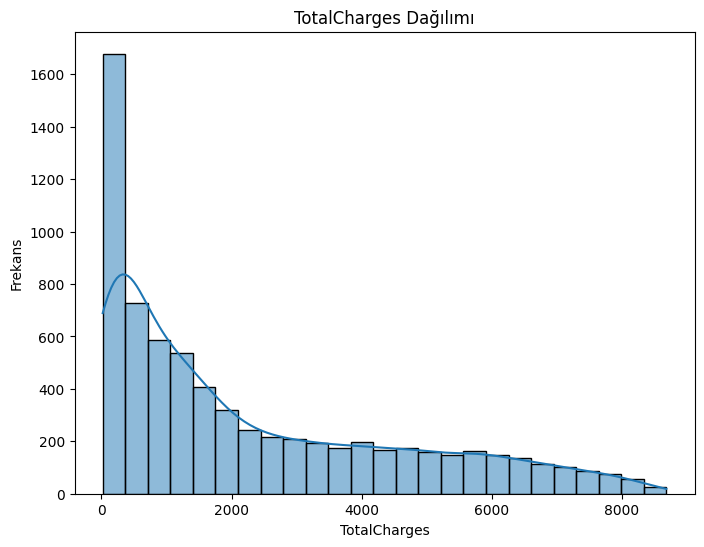

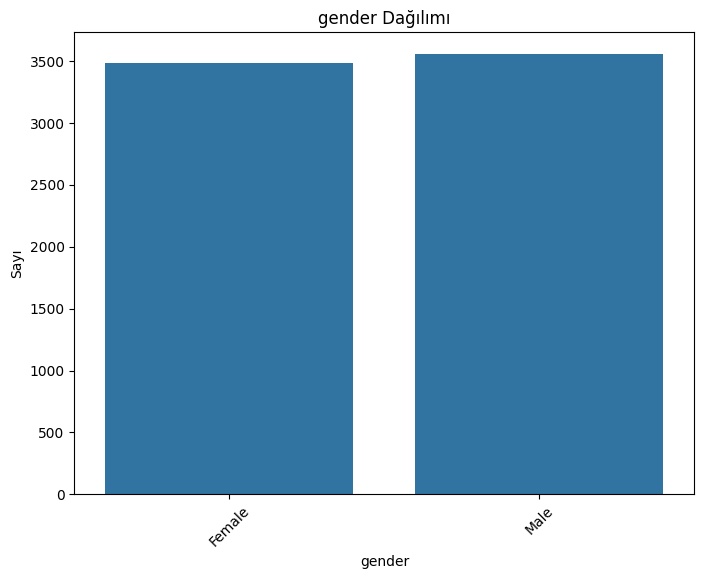

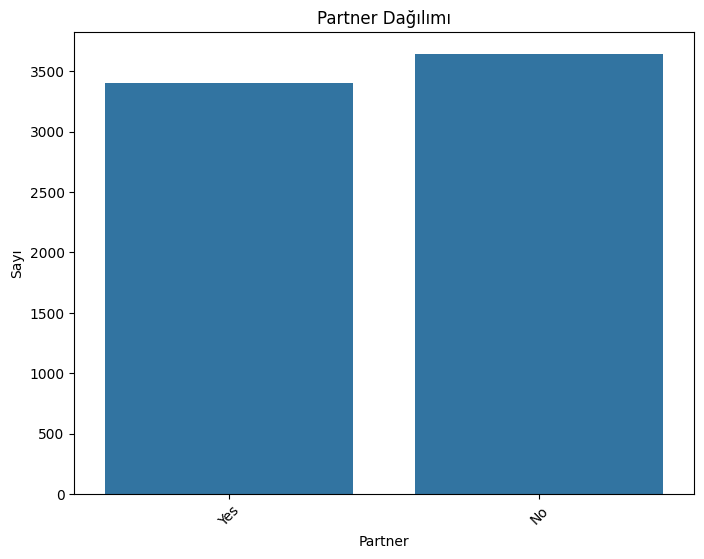

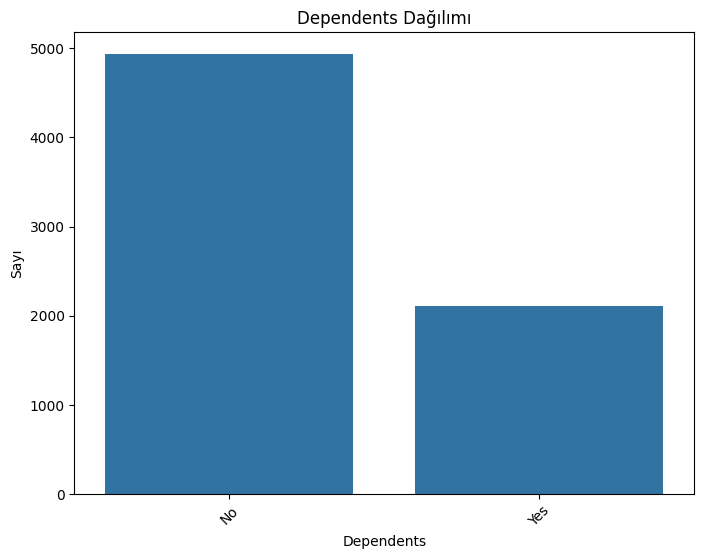

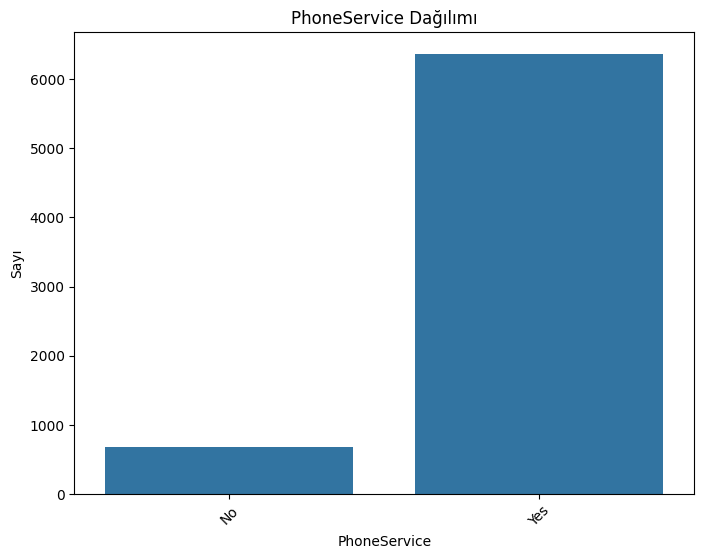

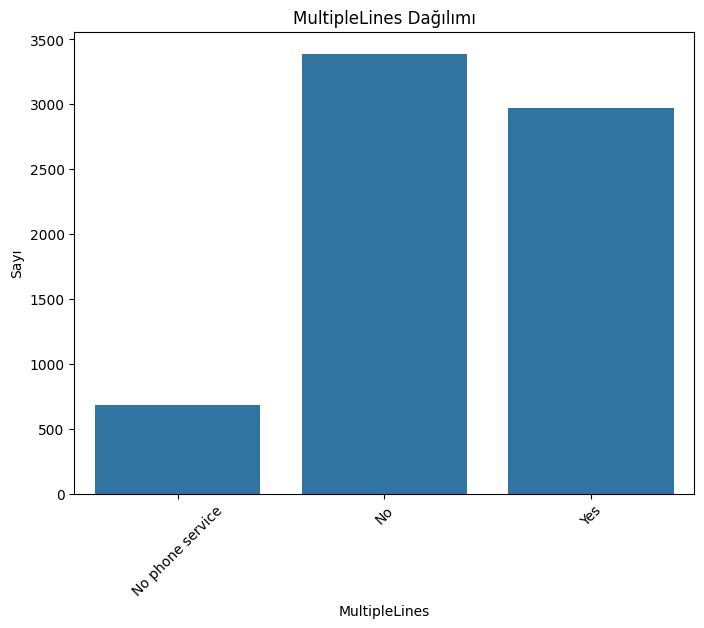

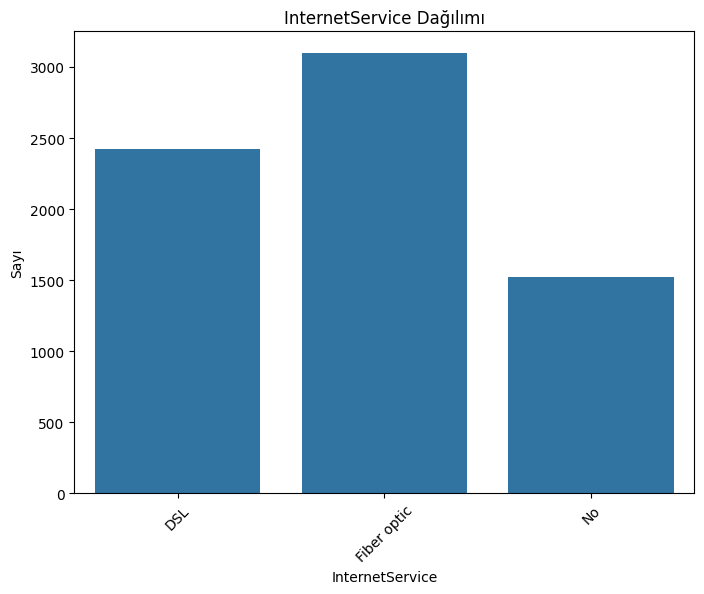

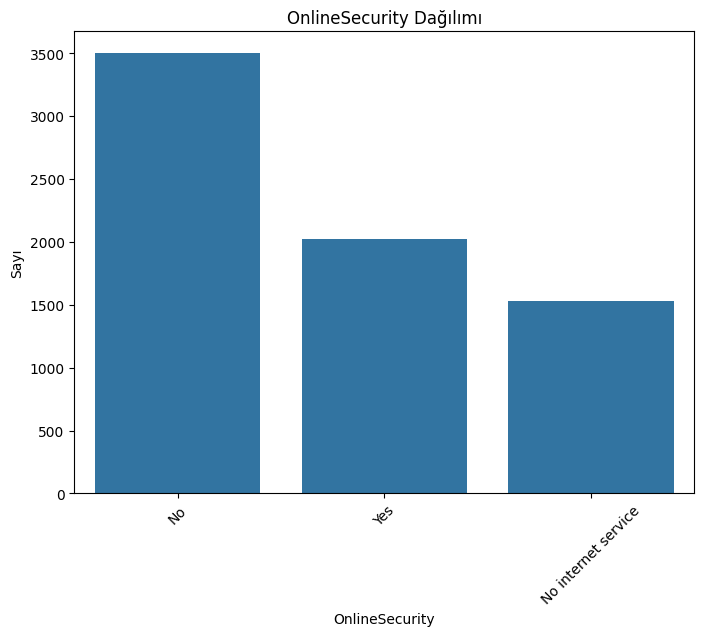

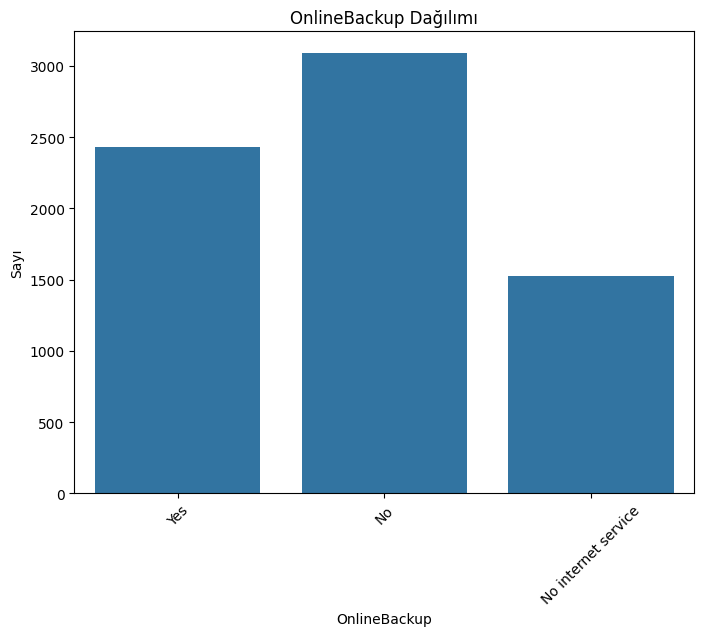

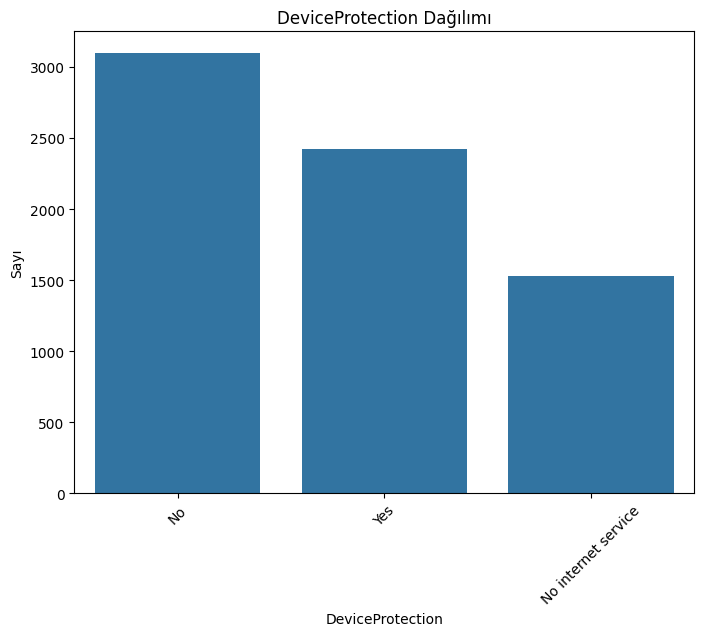

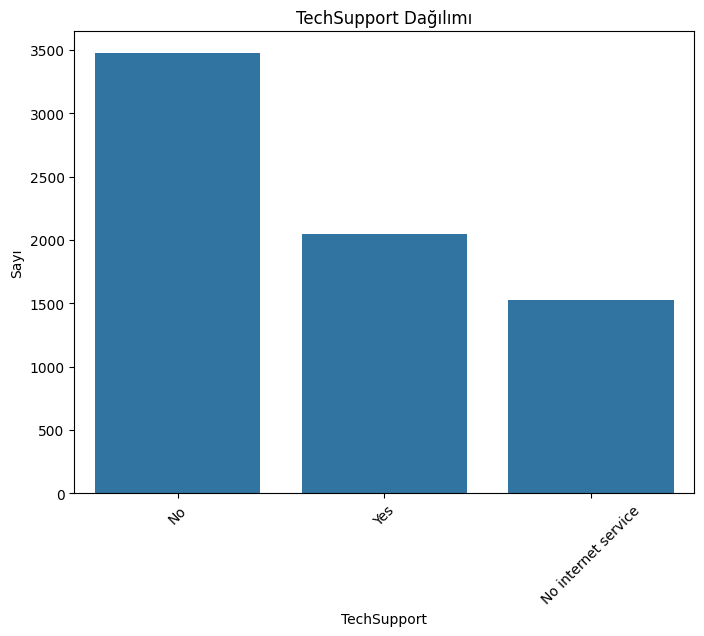

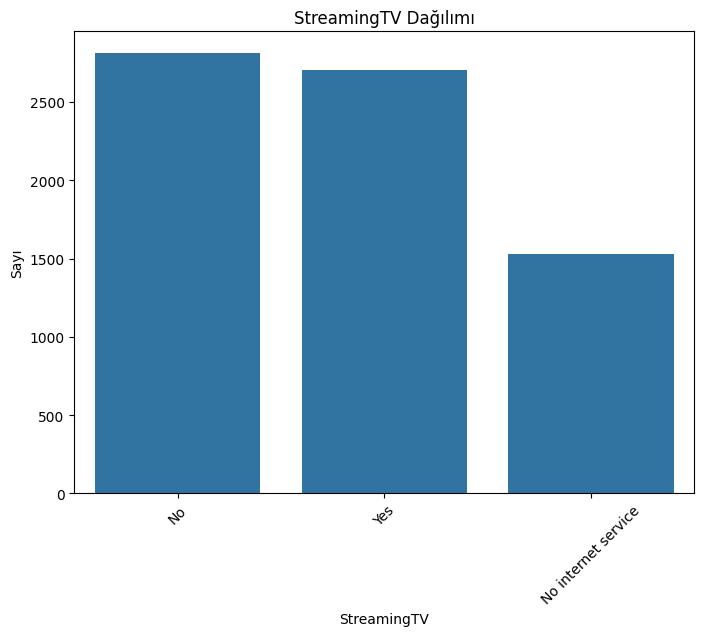

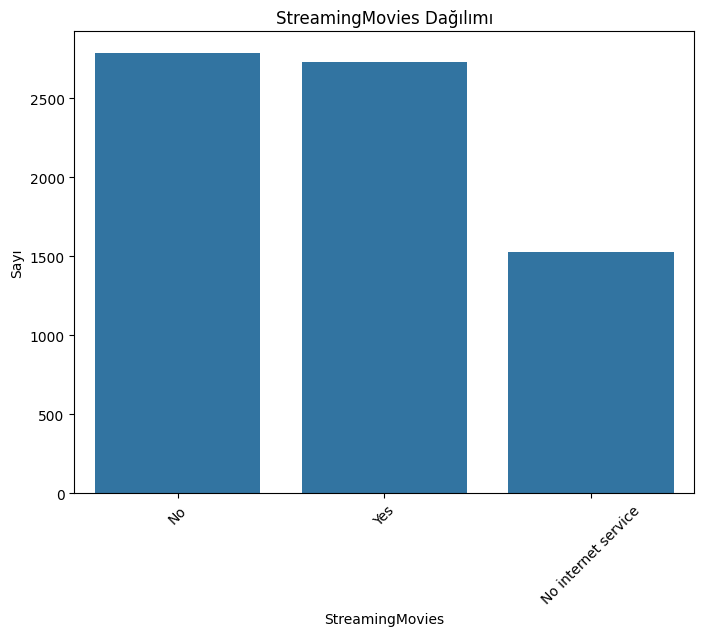

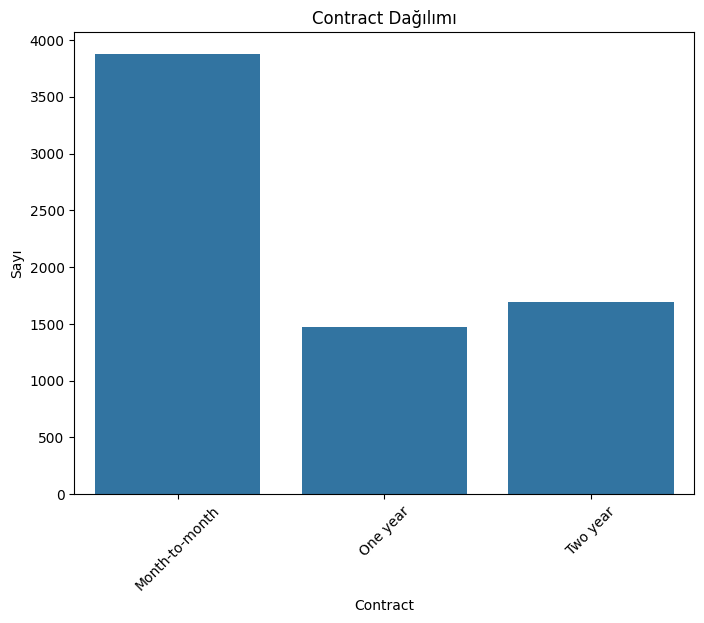

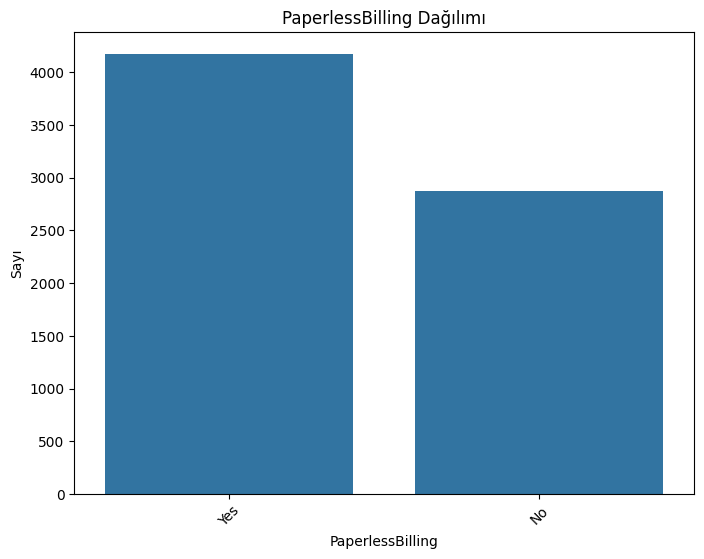

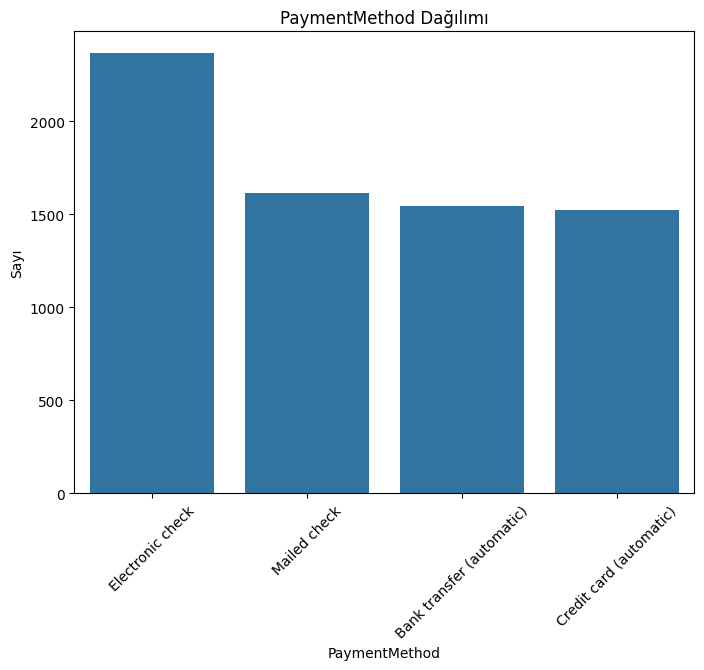

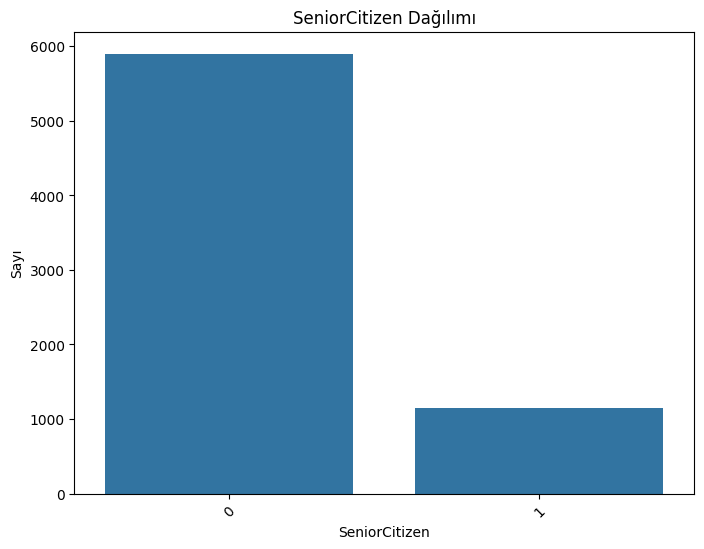

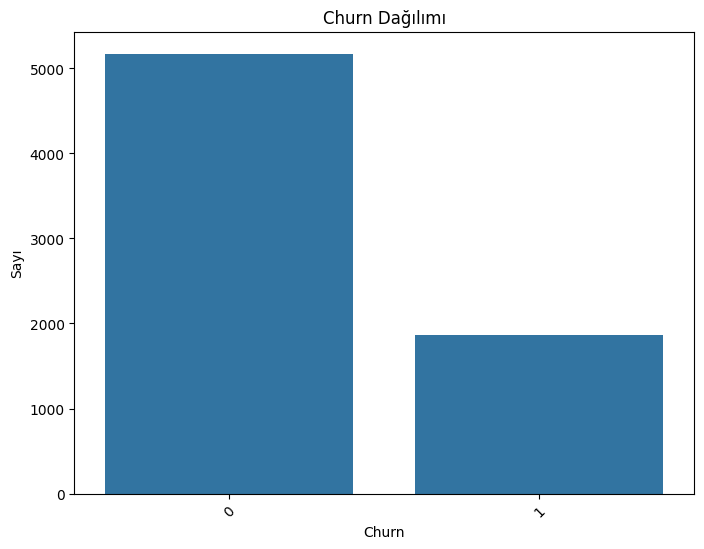

In [393]:
# Numerik ve kategorik değişkenlerin veri içindeki dağılımının gözlemlenmesi:

import matplotlib.pyplot as plt
# Numerik değişkenlerin dağılımını inceleyelim
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.show()

# Kategorik değişkenlerin dağılımını inceleyelim
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col])
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Sayı")
    plt.xticks(rotation=45)
    plt.show()


In [394]:
# No phone service geçen verileri No olarak değiştirilmesş ve  No internet service geçen verileri de No ile değiştirilmesi

df.replace('No phone service','No',inplace=True)
df.replace('No internet service','No',inplace=True)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


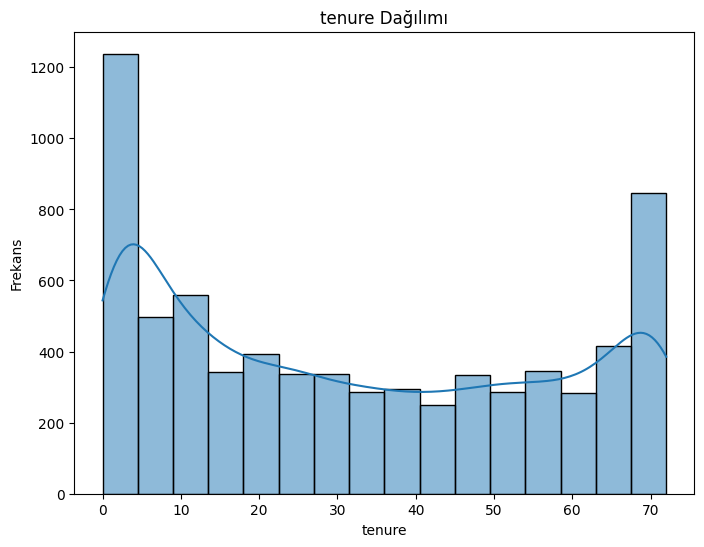

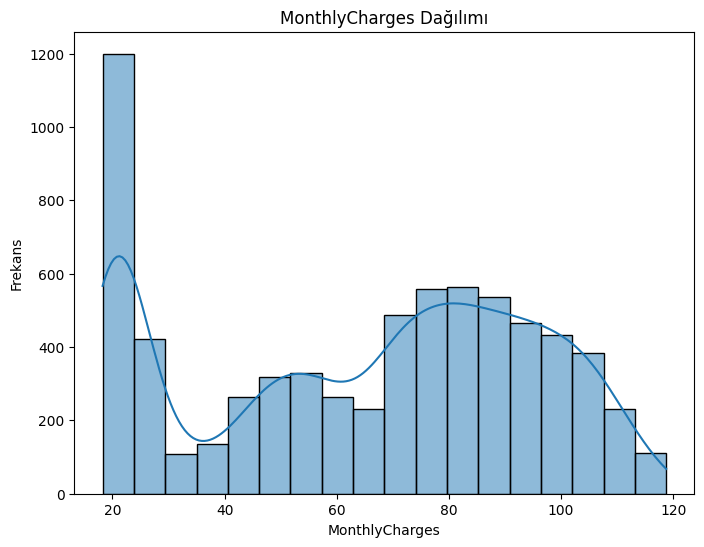

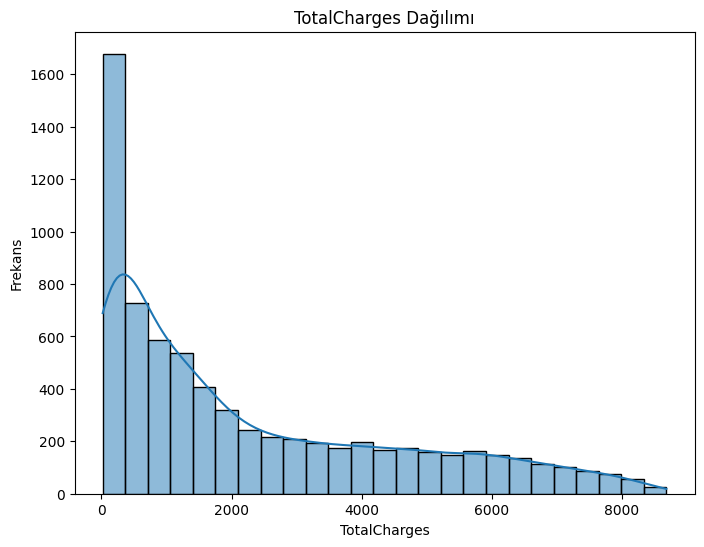

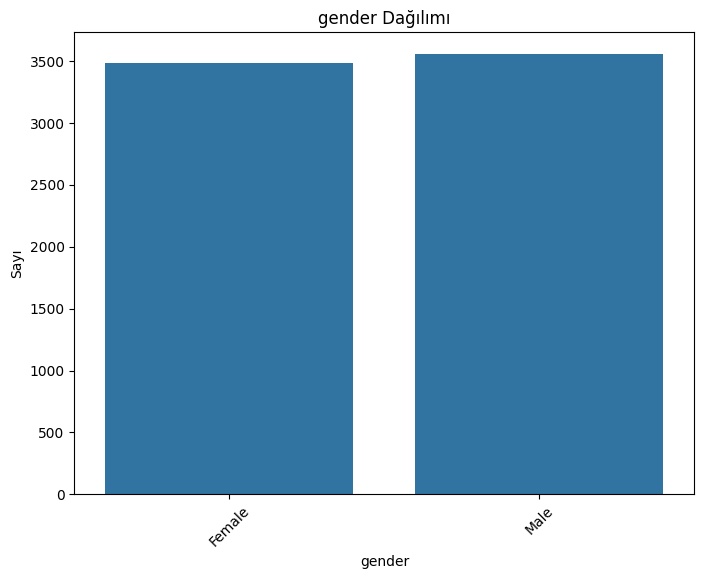

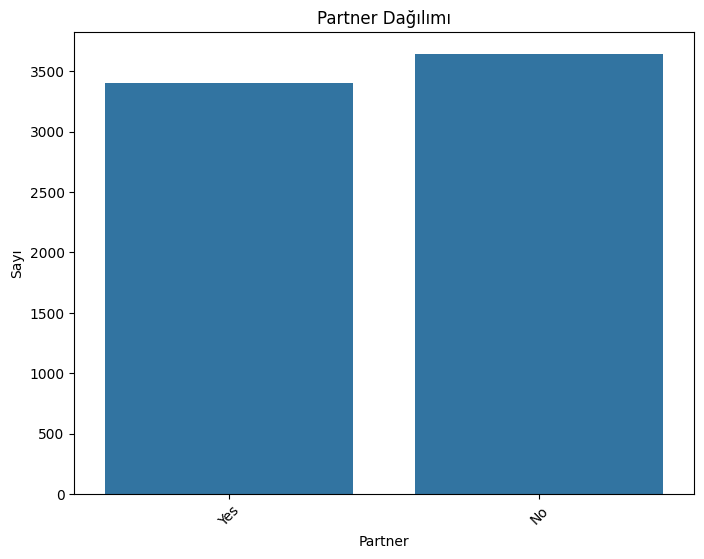

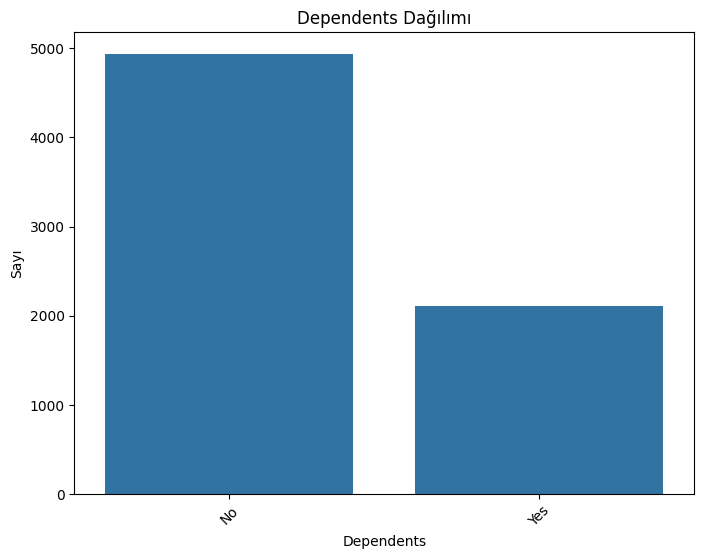

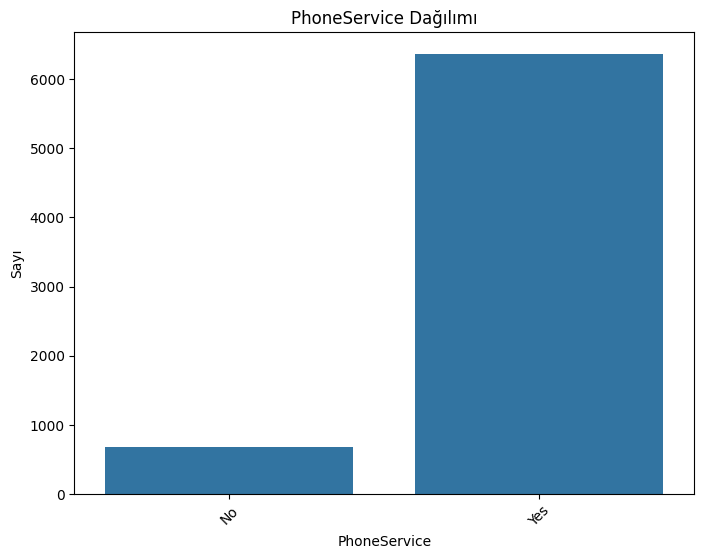

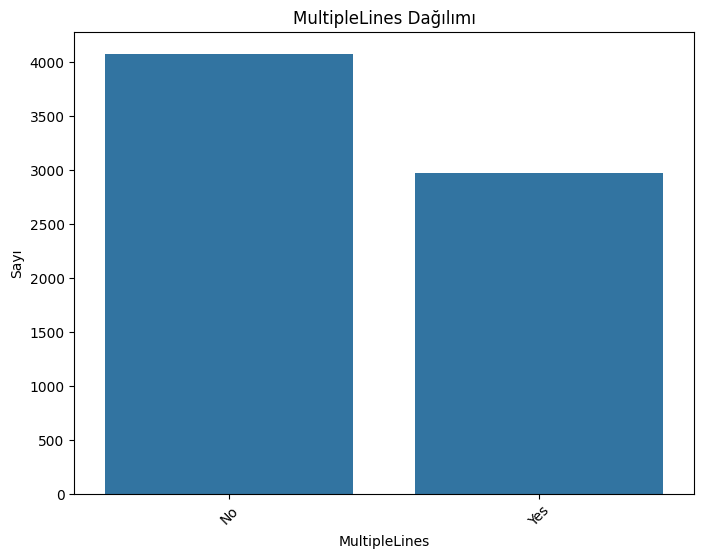

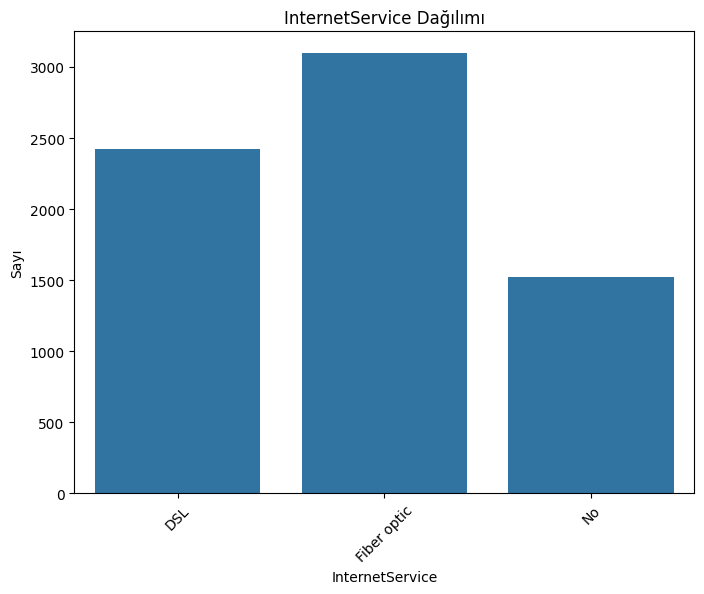

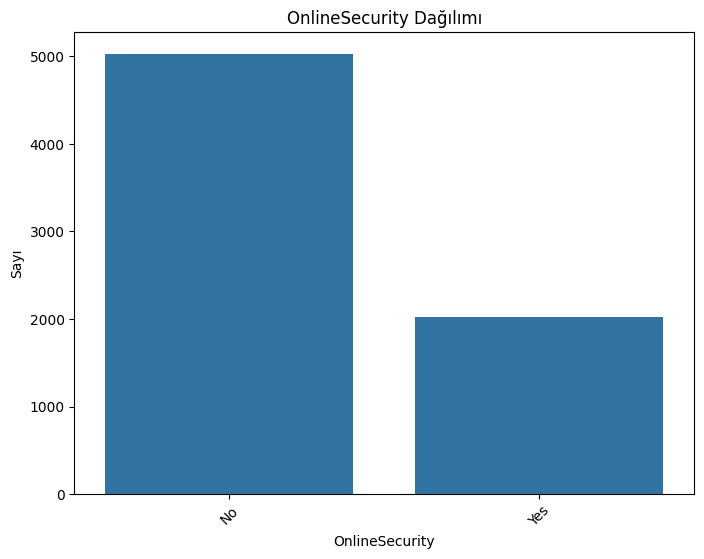

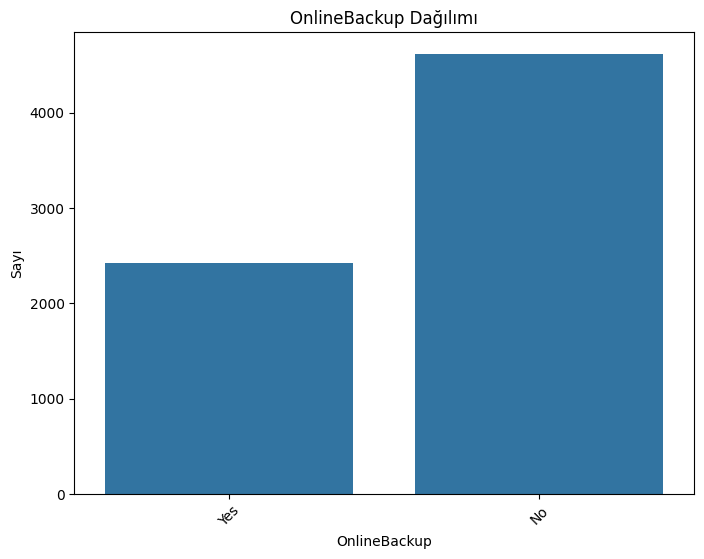

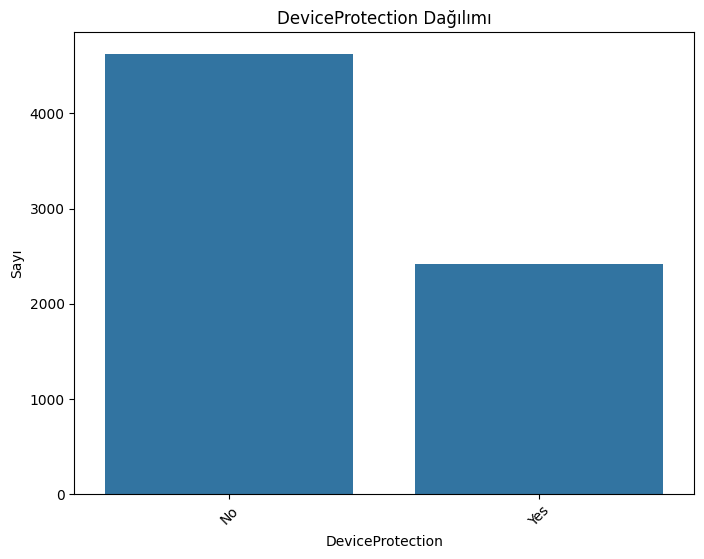

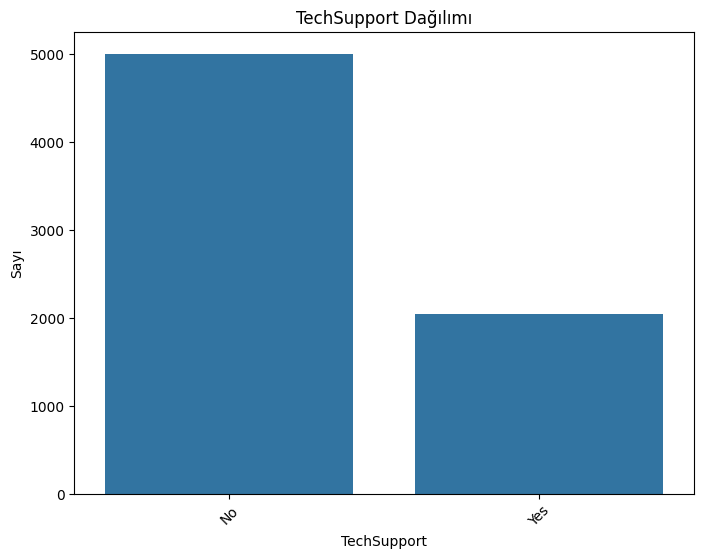

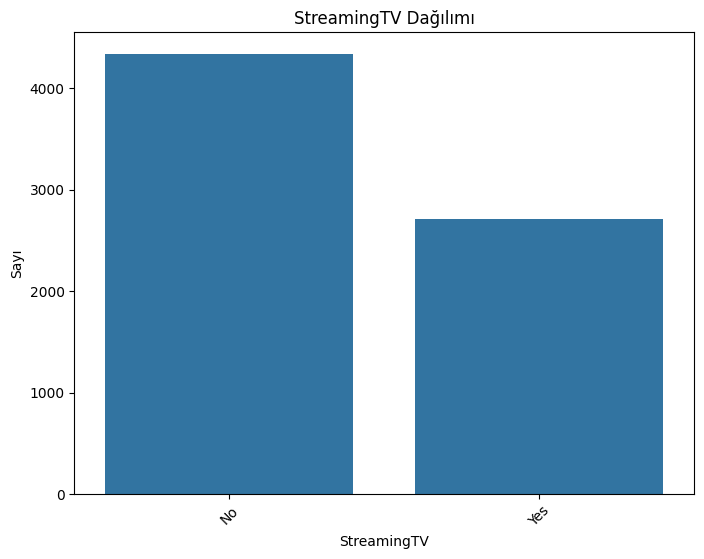

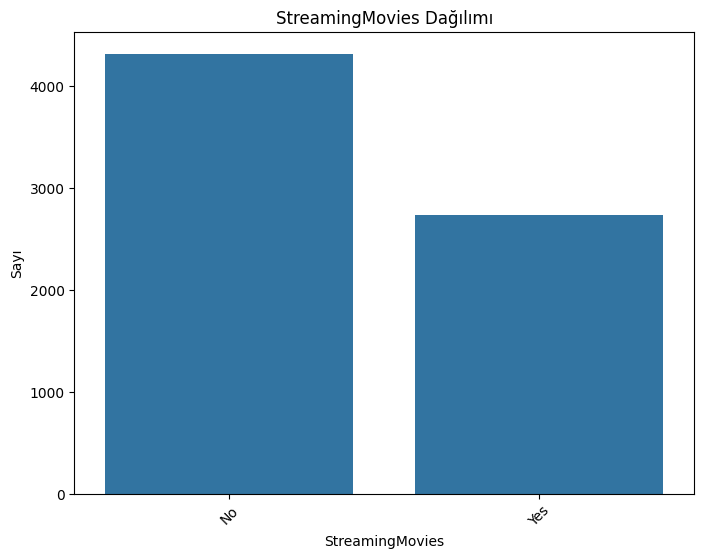

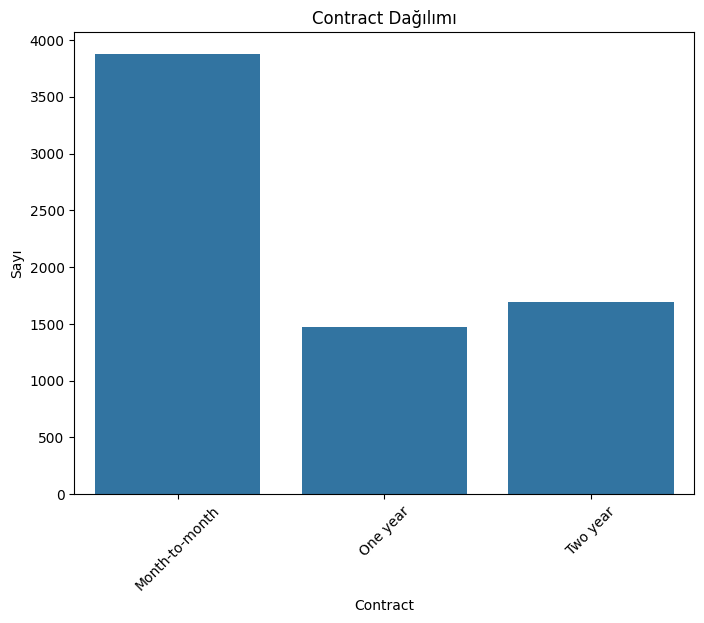

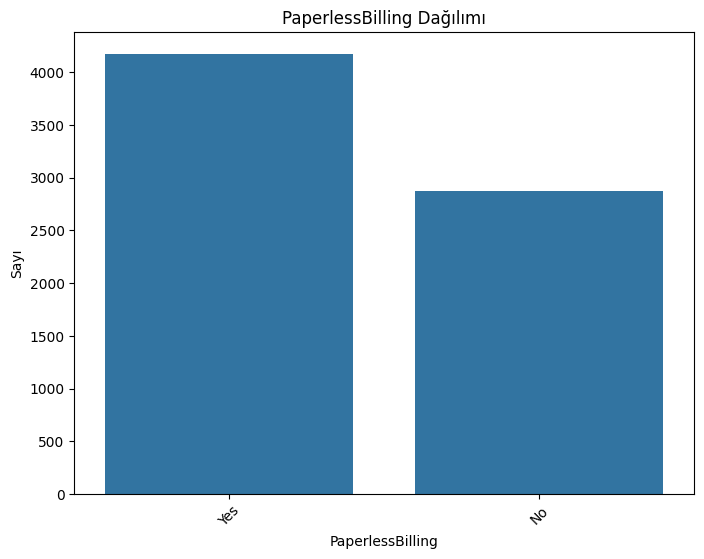

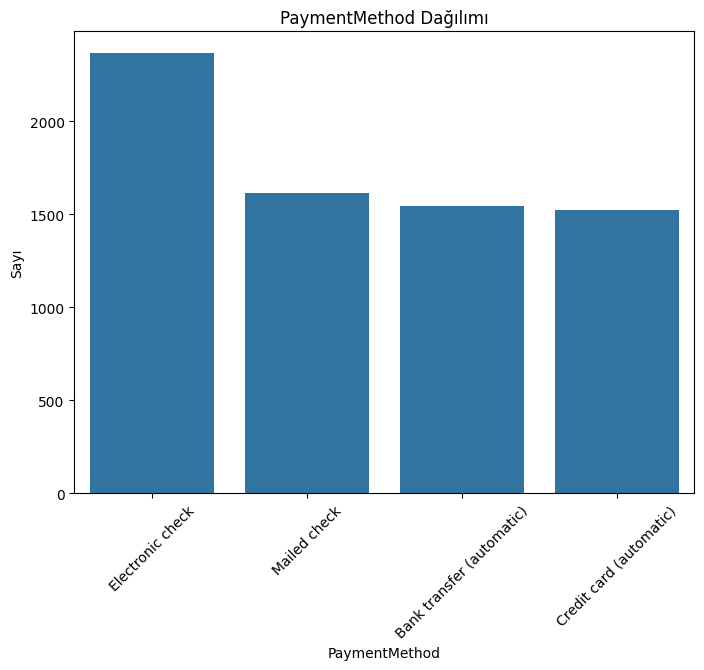

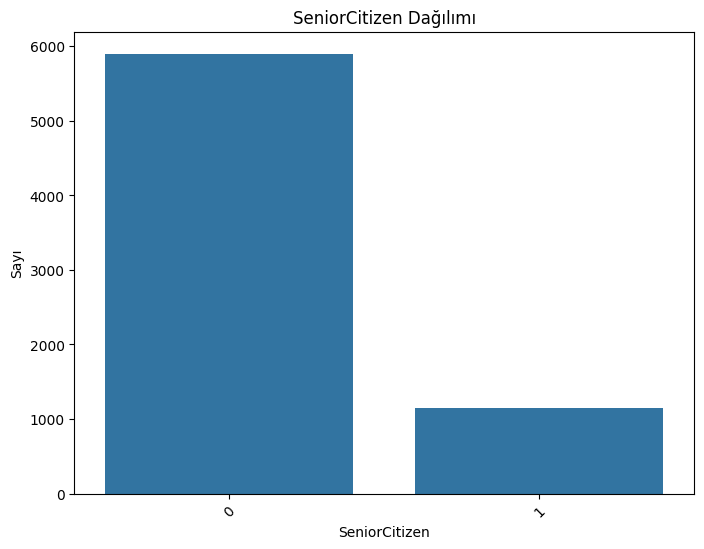

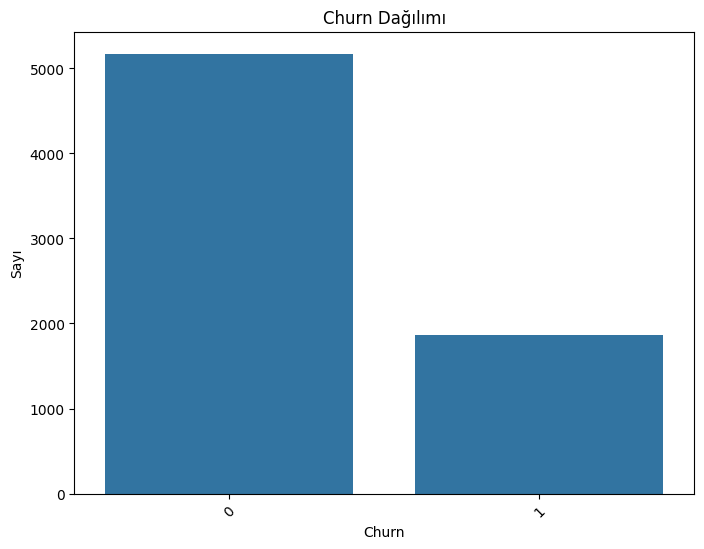

In [395]:
# Tekrar Numerik ve kategorik değişkenlerin veri içindeki dağılımının gözlemlenmesi

import matplotlib.pyplot as plt
# Numerik değişkenlerin dağılımını inceleyelim
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.show()

# Kategorik değişkenlerin dağılımını inceleyelim
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col])
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Sayı")
    plt.xticks(rotation=45)
    plt.show()

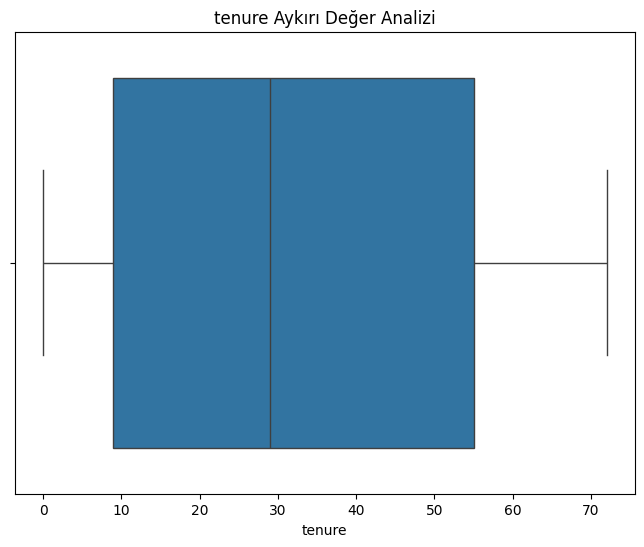

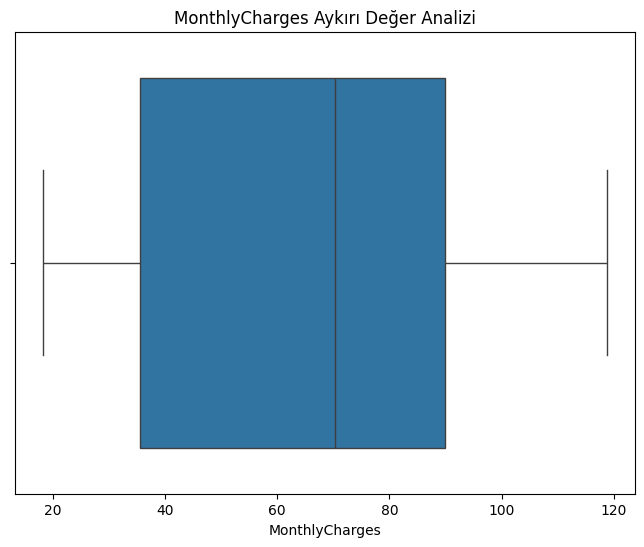

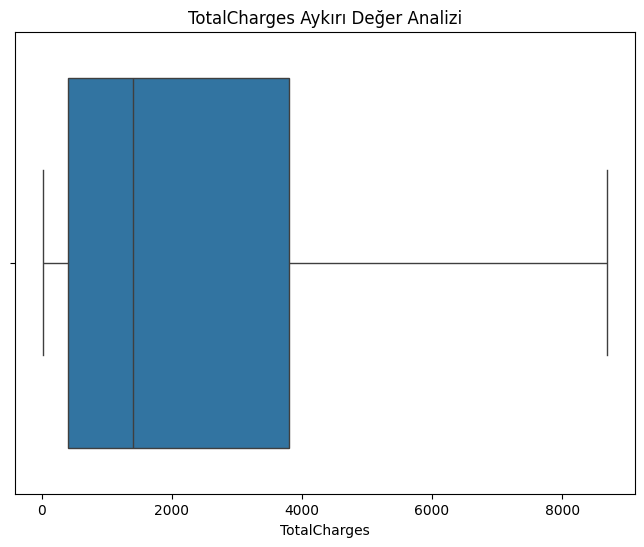

In [396]:
# Aykırı gözlem incelenmesi:

import matplotlib.pyplot as plt
# Aykırı değerleri görselleştirmek için boxplot kullandık
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f"{col} Aykırı Değer Analizi")
    plt.xlabel(col)
    plt.show()


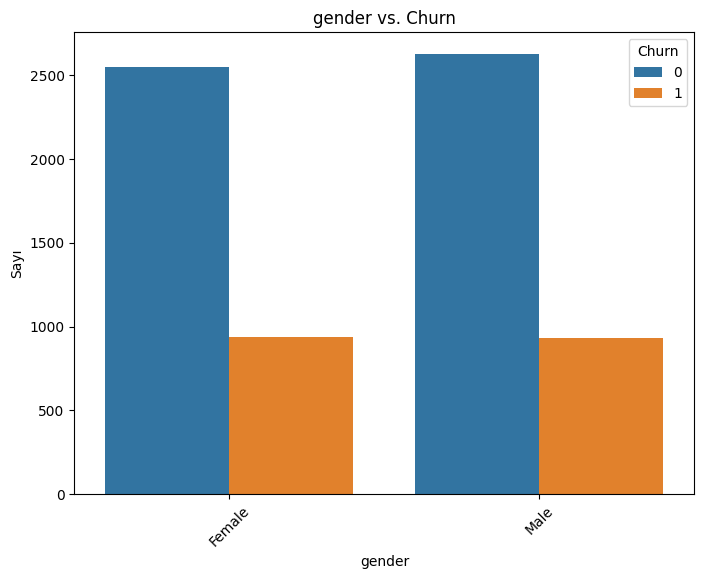

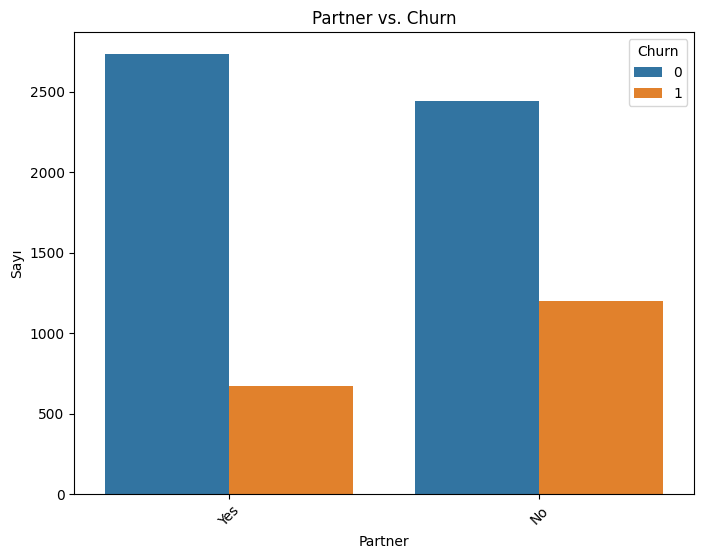

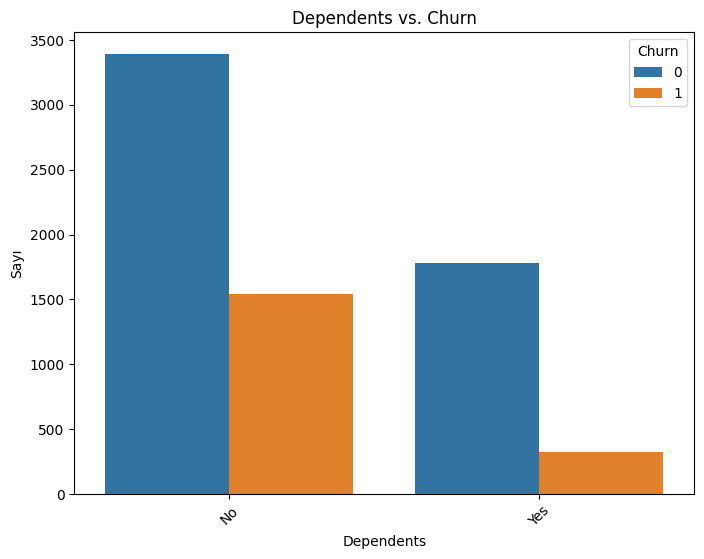

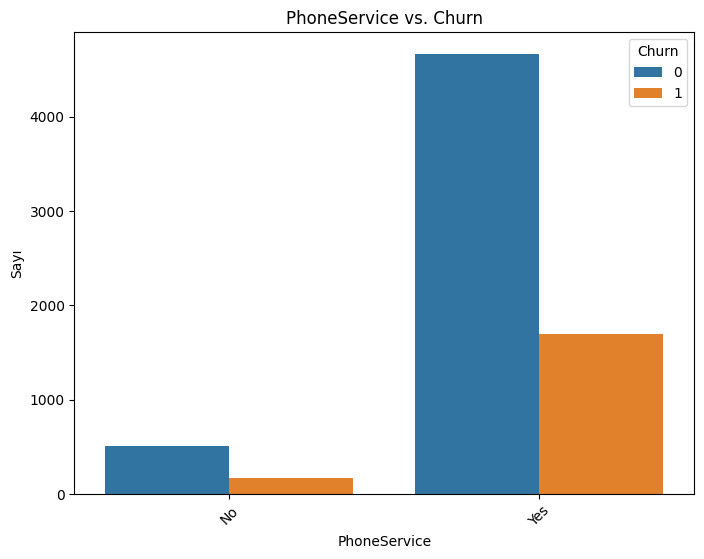

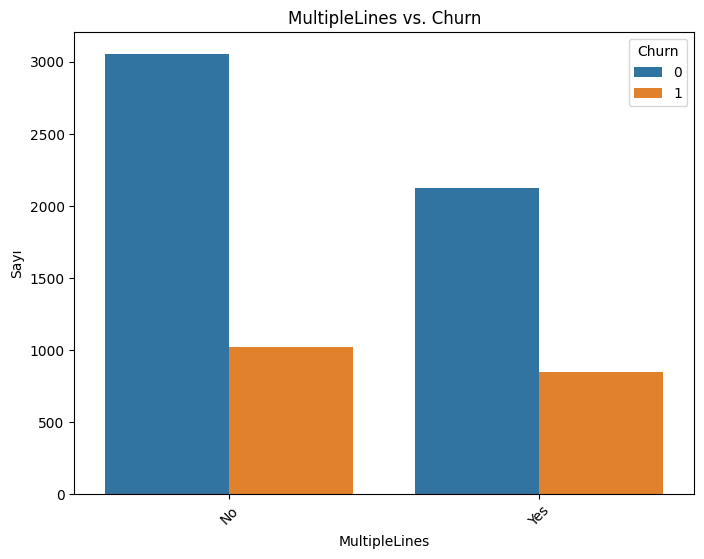

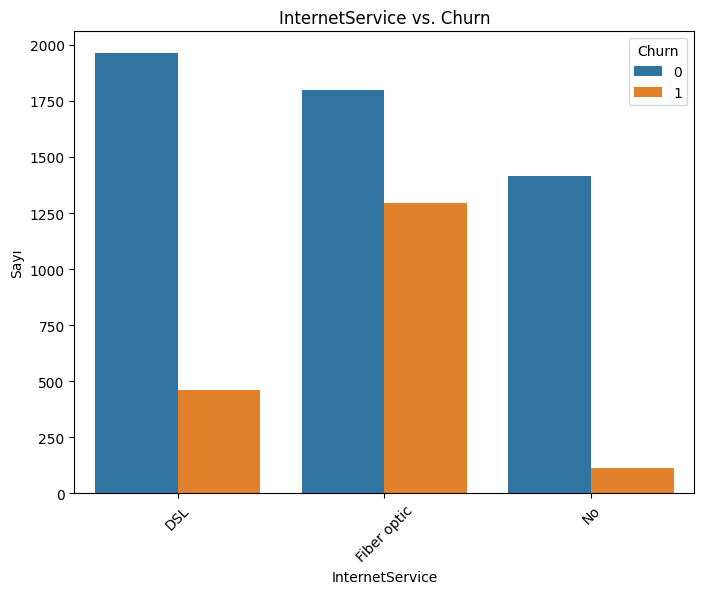

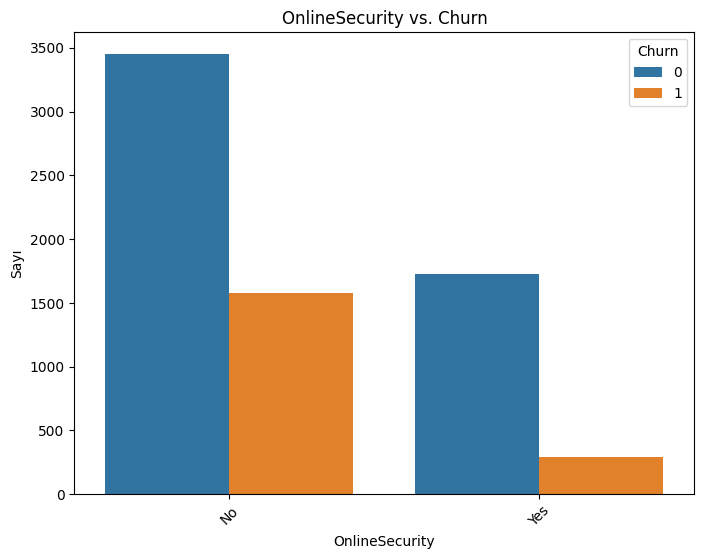

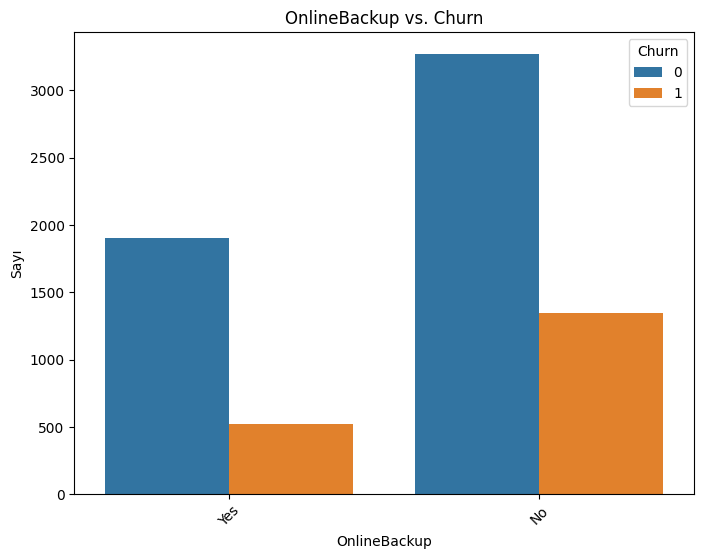

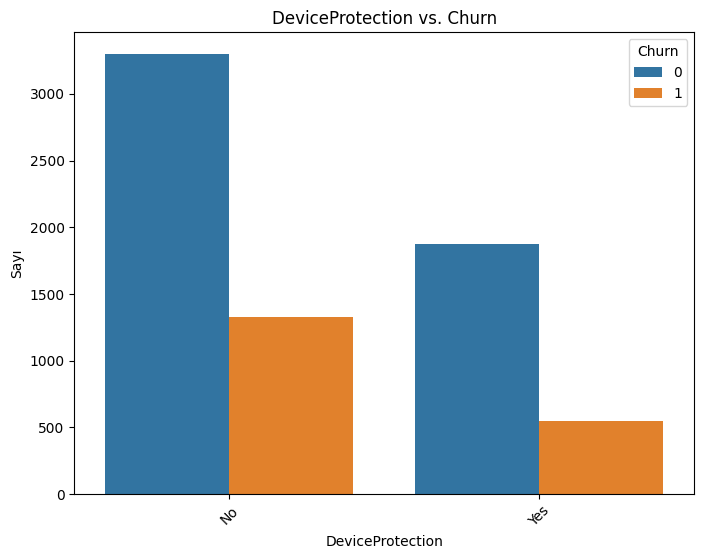

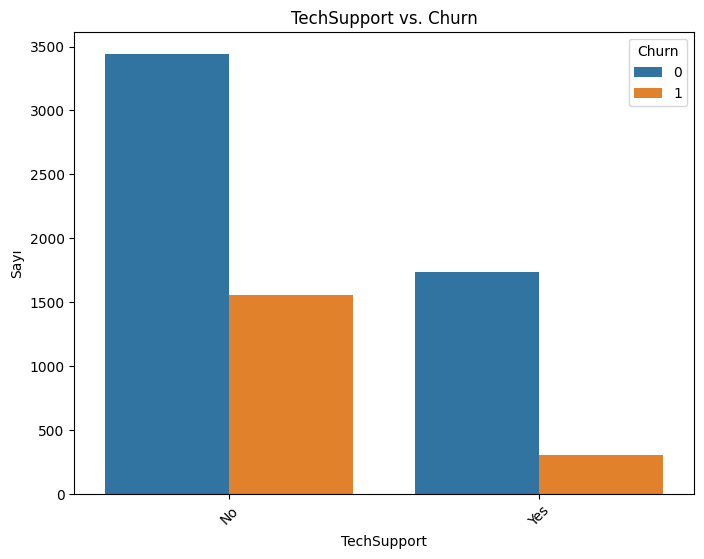

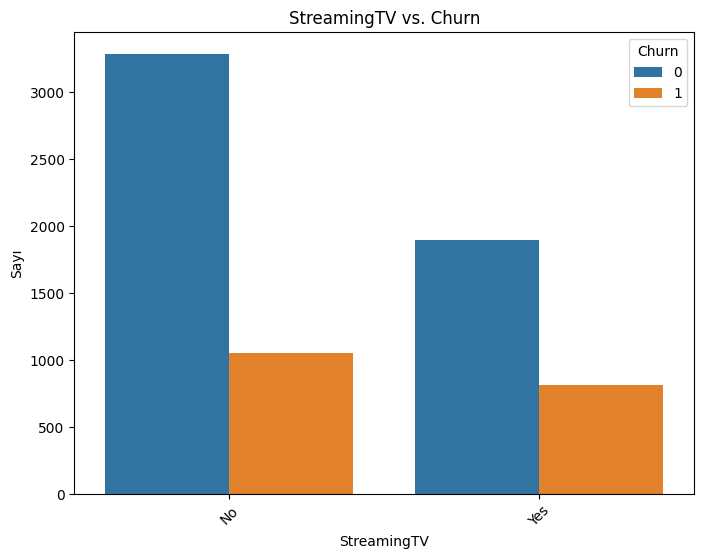

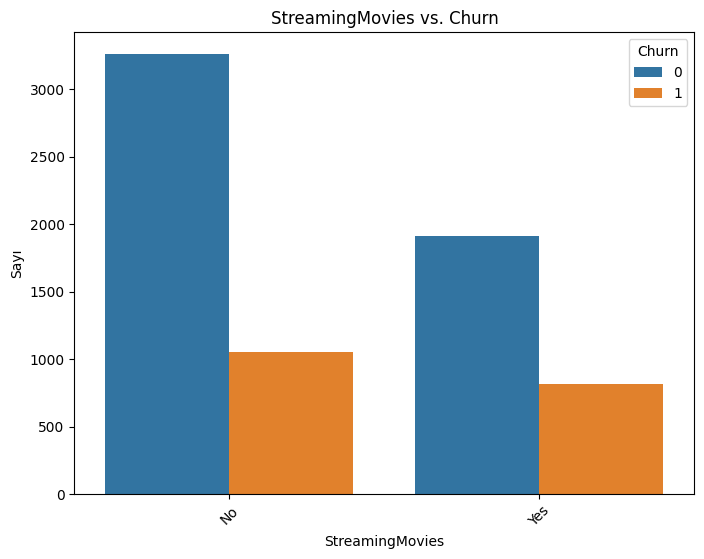

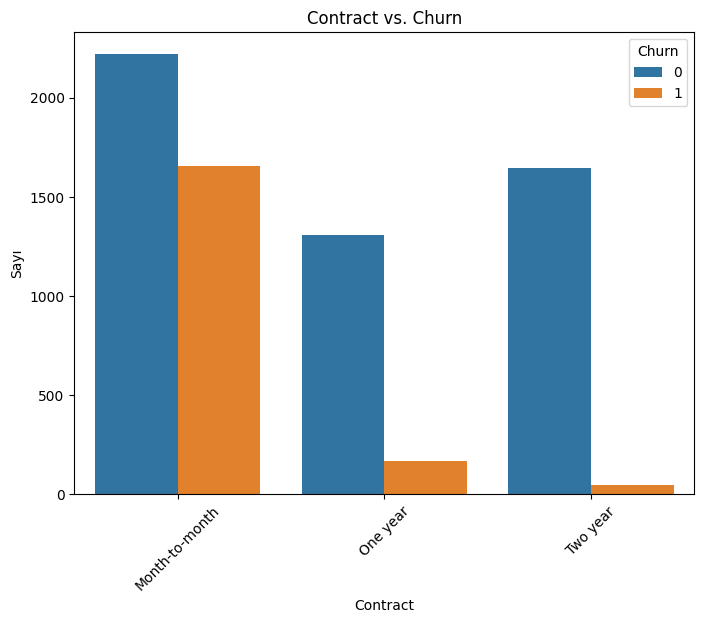

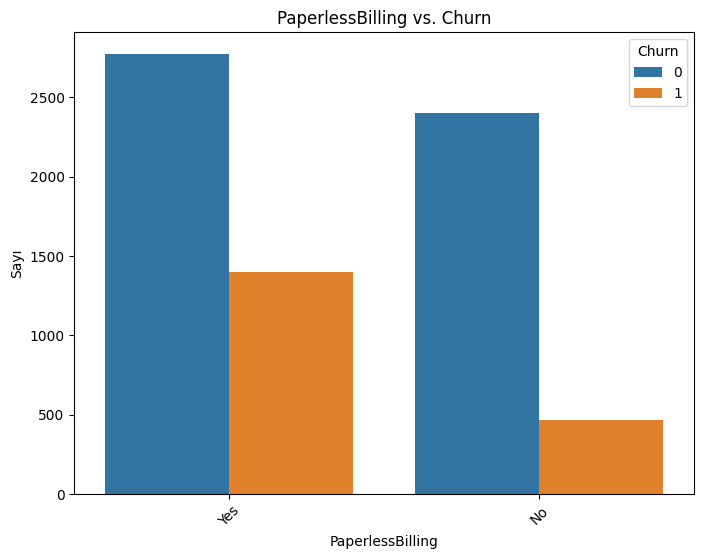

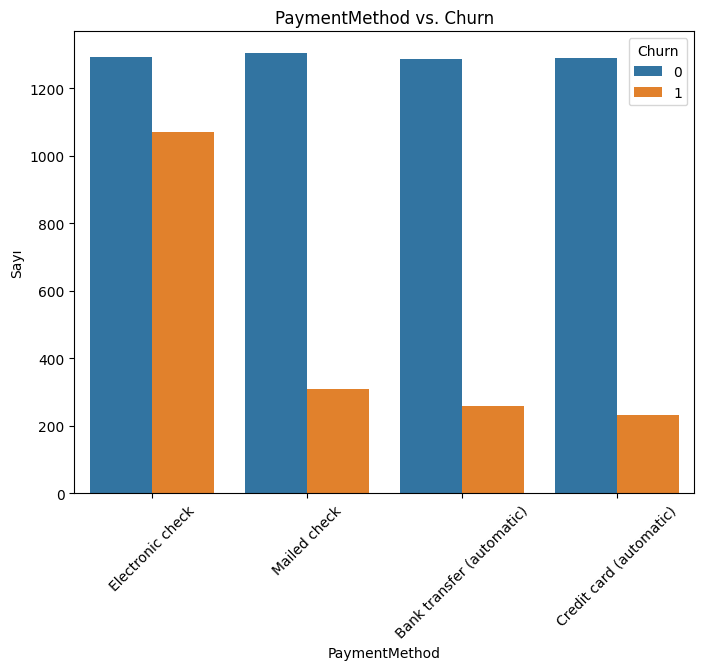

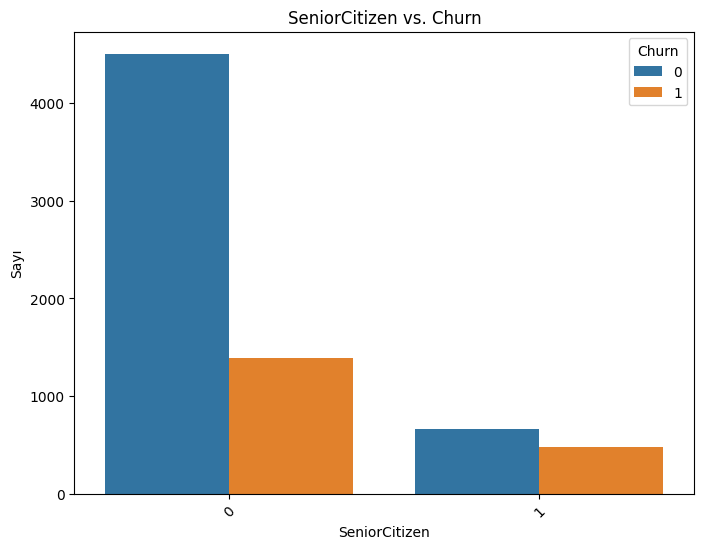

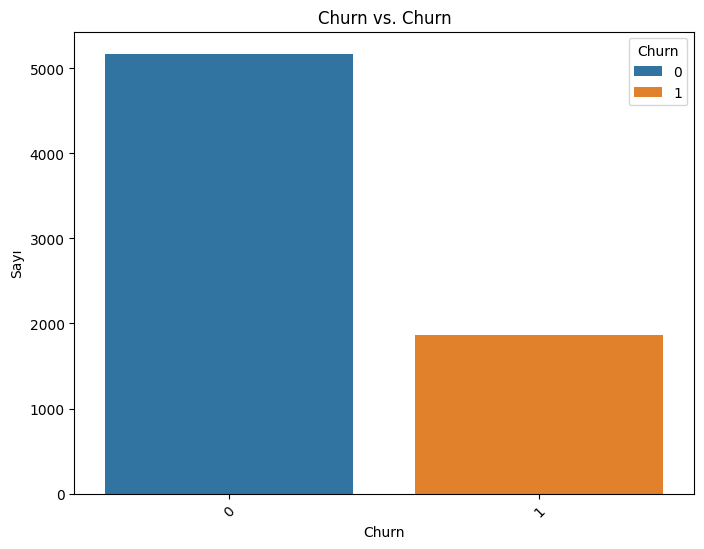

In [397]:
# Kategorik değişkenler ile hedef değişken incelemesininin yapılması:

import matplotlib.pyplot as plt
# Kategorik değişkenler ile hedef değişken incelemesi:
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col], hue=df['Churn'])
    plt.title(f"{col} vs. Churn")
    plt.xlabel(col)
    plt.ylabel("Sayı")
    plt.xticks(rotation=45)
    plt.legend(title='Churn')
    plt.show()


In [398]:
# prompt: Performansı arttırmak için yeni değişkenler oluşturulması

# Toplam harcamaların aylık harcamalara oranını hesaplayarak yeni bir değişken oluşturalım.
df['MonthlyChargesRatio'] = df['TotalCharges'] / df['MonthlyCharges']

# Sözleşme süresinin uzunluğuna göre yeni bir kategorik değişken oluşturalım.
df['ContractLength'] = df['Contract'].apply(lambda x: 1 if x == 'Month-to-month' else (12 if x == 'One year' else 24))

# İnternet hizmetinin olup olmamasına göre yeni bir değişken oluşturalım.
df['HasInternetService'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)

# Ek hizmetlerin sayısını hesaplayarak yeni bir değişken oluşturalım.
df['NumberOfAdditionalServices'] = (df['OnlineSecurity'] == 'Yes').astype(int) + \
                                   (df['OnlineBackup'] == 'Yes').astype(int) + \
                                   (df['DeviceProtection'] == 'Yes').astype(int) + \
                                   (df['TechSupport'] == 'Yes').astype(int) + \
                                   (df['StreamingTV'] == 'Yes').astype(int) + \
                                   (df['StreamingMovies'] == 'Yes').astype(int)


In [399]:

# Creating yearly categorical variables from the 'tenure' feature
# to understand customer loyalty in terms of year ranges.
df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"] > 60) & (df["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

# Marking customers with 1 or 2-year contracts as 'Engaged' to identify potentially loyal customers.
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

# Identifying customers who do not have any of the support, backup, or protection services.
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (
        x["TechSupport"] != "Yes") else 0, axis=1)

# Identifying young, not engaged (monthly contracts) customers potentially at higher risk of churning.
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0,
                                       axis=1)

# Counting the total number of services each customer has subscribed to.
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                               'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# Identifying customers who have subscribed to any streaming service.
df["NEW_FLAG_ANY_STREAMING"] = df.apply(
    lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Marking customers who use automatic payment methods.
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(
    lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

# Calculating the average monthly charges.
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

# Identifying the increase in current charges compared to the average charges.
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Calculating the average service fee per subscribed service.
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

# Viewing the head of the modified dataframe and its new shape after feature extraction.
df.head()
df.shape


(7043, 35)

In [400]:
# 'tenure' sütununu kategorilere ayırmak için fonksiyon.
def create_tenure_category(dataframe):
    bins = [0, 12, 24, 48, 60, 84, 120, 240]
    labels = ['0-1Y', '1-2Y', '2-4Y', '4-5Y', '5-7Y', '7-10Y', '10Y+']
    dataframe["tenure_cat"] = pd.cut(dataframe["tenure"], bins=bins, labels=labels, include_lowest=True)


create_tenure_category(df)  # Fonksiyonu çalıştırarak yeni özelliği :


# Yeni özellikler ekleme
df["engaged"] = df["Contract"].apply(lambda x: 1 if x == "Month-to-month" else 0)
df["avg_monthly_fee"] = df["TotalCharges"] / (df["tenure"] + 1)

In [401]:
# prompt: kategorik değişkenler için onehot encoding:

import pandas as pd
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)


In [402]:
# Sınıflandırma için hedef değişken ve özellikleri ayılması:
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

In [403]:
# Kategorik değişkenleri etiketleme ve one-hot encoding yapma:
cat_cols = X.select_dtypes(include=['object']).columns

# Label Encoding
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# One-Hot Encoding
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [404]:
# Eksik ve aykırı gözlemler için gerekli işlemleri yapılması:
# Eksik değerleri doldurma veya silme
df.dropna(inplace=True)  # Eksik değerleri içeren satırları silme

# Aykırı değerleri işlemek için IQR yöntemini kullanma
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower_bound, upper_bound)  # Aykırı değerleri sınırlarla değiştirme


In [405]:
# prompt: # Numerik değişkenler için standartlaştırma yapılması

from sklearn.preprocessing import StandardScaler

# Numerik sütunları seç
num_cols = X.select_dtypes(include=['float', 'int']).columns

# StandardScaler oluştur
scaler = StandardScaler()

# Numerik sütunları ölçeklendir
X[num_cols] = scaler.fit_transform(X[num_cols])


In [406]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [407]:
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]
X_test_clean = X_test.dropna()
y_test_clean = y_test[X_test_clean.index]

In [408]:
# prompt: standartlaştırma yapılması
# Numerik sütunları seç
num_cols = X.select_dtypes(include=['float', 'int']).columns

# StandardScaler oluştur
scaler = StandardScaler()

# Numerik sütunları ölçeklendir
X[num_cols] = scaler.fit_transform(X[num_cols])


In [409]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Veri setinizi bölün
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Eksik verileri işleyin
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Modelleri eğitin ve tahmin edin
log_model = LogisticRegression().fit(X_train_imputed, y_train)
log_y_pred = log_model.predict(X_test_imputed)
log_accuracy = accuracy_score(y_test, log_y_pred)
print("Logistic Regression Accuracy:", log_accuracy)

knn_model = KNeighborsClassifier().fit(X_train_imputed, y_train)
knn_y_pred = knn_model.predict(X_test_imputed)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)

dt_model = DecisionTreeClassifier().fit(X_train_imputed, y_train)
dt_y_pred = dt_model.predict(X_test_imputed)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print("Decision Tree Accuracy:", dt_accuracy)

rf_model = RandomForestClassifier().fit(X_train_imputed, y_train)
rf_y_pred = rf_model.predict(X_test_imputed)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("Random Forest Accuracy:", rf_accuracy)

# En iyi modeli seçin
best_model = max([(log_accuracy, "Logistic Regression"),
                  (knn_accuracy, "K-Nearest Neighbors"),
                  (dt_accuracy, "Decision Tree"),
                  (rf_accuracy, "Random Forest")])[1]
print("Best Performing Model:", best_model)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8012304779933743
K-Nearest Neighbors Accuracy: 0.7695220066256507
Decision Tree Accuracy: 0.7392333175579744
Random Forest Accuracy: 0.7936583057264552
Best Performing Model: Logistic Regression


In [410]:
# Modeli ağırlıklandırarak eğitin
log_model = LogisticRegression(class_weight='balanced').fit(X_train_scaled, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [411]:
from imblearn.over_sampling import SMOTE

# SMOTE ile veri dengesizliğini gidermek
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Modeli SMOTE ile dengelenmiş verilerle eğitin
log_model = LogisticRegression().fit(X_train_smote, y_train_smote)
df.shape


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(7032, 63)

In [412]:
# Veri setinizi ölçeklendirin
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Modeli tekrar eğitin
log_model = LogisticRegression(max_iter=500).fit(X_train_scaled, y_train)
log_y_pred = log_model.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, log_y_pred)
print("Logistic Regression Accuracy (Scaled):", log_accuracy)


Logistic Regression Accuracy (Scaled): 0.8035967818267865


In [413]:
# hiperparametre optimizasyonu yapılması ve modelin tekrar kurulması:

# Hiperparametre optimizasyonu için GridSearchCV kullanma
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# En iyi hiperparametreleri ve modeli yazdırma
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# En iyi modeli kullanarak tahmin yapma
best_log_model = grid_search.best_estimator_
best_log_y_pred = best_log_model.predict(X_test_scaled)
best_log_accuracy = accuracy_score(y_test, best_log_y_pred)
print("Logistic Regression Accuracy (Optimized):", best_log_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Model: LogisticRegression(C=1, max_iter=500, solver='liblinear')
Logistic Regression Accuracy (Optimized): 0.8031235210601041


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [416]:
# en iyi parametrelere göre modelin tekrar kurulması ve performans değerlendirme
# scorelarını yazdır

# En iyi hiperparametreleri kullanarak modeli tekrar eğitin
best_params = grid_search.best_params_
best_model = LogisticRegression(max_iter=500, **best_params).fit(X_train_scaled, y_train)

# Test verileri üzerinde tahmin yapın
y_pred = best_model.predict(X_test_scaled)

# Metrikleri hesaplayın
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Sonuçları yazdırın
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Precision:", precision)
print("F1 Score:", f1)


Accuracy: 0.8031235210601041
ROC AUC Score: 0.7157363825100239
Precision: 0.6779279279279279
F1 Score: 0.5913555992141454


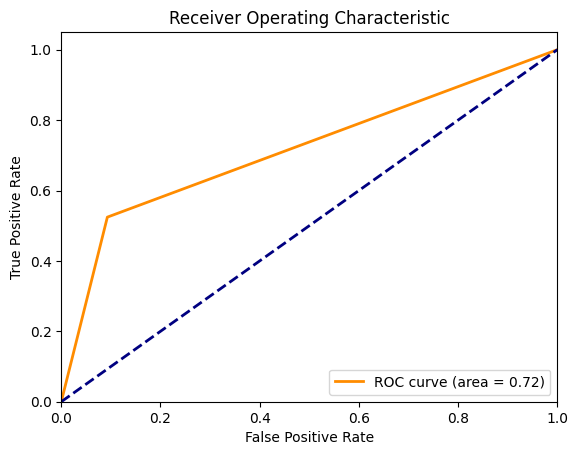

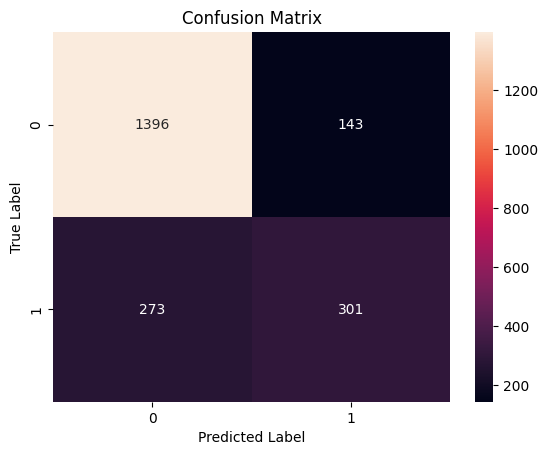

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.68      0.52      0.59       574

    accuracy                           0.80      2113
   macro avg       0.76      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



In [418]:
# sonuçların görselleştirilmesi

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiz
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
